# Home Exercise on Neural Network
Implement a **Neural Network model** using **fully connected layers, non-linear activation, skip connections, dropout, etc.** (Note that you are only allowed to use **MLP blocks** and must not use **CNNs, Transformers, or other advanced deep learning architectures**) (Can train on a 10GB GPU ).

Data: **MNIST datasets**

# Import Library

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

+ Check the gpu cuda

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Downloading the data using gdown

In [7]:
!gdown 19UHcwnKdFmxP_ucNGA70an42B7JPL8ZS -O digit-recognizer.zip
!unzip digit-recognizer.zip

Downloading...
From: https://drive.google.com/uc?id=19UHcwnKdFmxP_ucNGA70an42B7JPL8ZS
To: /content/digit-recognizer.zip
100% 16.1M/16.1M [00:00<00:00, 165MB/s]
Archive:  digit-recognizer.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Load data from the competition

In [8]:
# # Load train data
# train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

# # Load test data
# test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# Load train data
train_data = pd.read_csv("train.csv")

# Load test data
test_data = pd.read_csv("test.csv")

# Train data: Features + Labels
X_train = train_data.iloc[:, 1:].values  # Bỏ cột đầu (label)
y_train = train_data.iloc[:, 0].values   # Cột đầu là label

X_train = X_train.astype('float32') / 255
y_train = y_train.astype('int64')

# Test data:
X_test = test_data.astype('float32') / 255

# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=46)

# Preprocessing

Because this data contain only pixel so we don't neet much preprocessing just convert to float and matrix

In [9]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.int64).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.int64).to(device)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)  # Chuyển đổi DataFrame sang mảng NumPy trước

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create the class model for using later

In [10]:
# Define the model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(X_train.shape[1], 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

+ Create an instance and define some loss function also optimizer

In [11]:
model = SimpleNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0007, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

# store some information
train_losses = []
test_losses = []
train_accs = []
test_accs = []
train_times = []

# Training the model

In [12]:
# Training loop
epochs = 50
for epoch in range(epochs):
    start_time = time.time()  # Bắt đầu tính thời gian huấn luyện

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc * 100)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val / total_val
    test_losses.append(val_loss)
    test_accs.append(val_acc * 100)

    epoch_time = time.time() - start_time  # Tính thời gian huấn luyện cho epoch này
    train_times.append(epoch_time)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Cập nhật learning rate
    scheduler.step(val_loss)

Epoch 1/50, Train Loss: 0.2340, Val Loss: 0.1061, Val Acc: 0.9714
Epoch 2/50, Train Loss: 0.1065, Val Loss: 0.0977, Val Acc: 0.9702
Epoch 3/50, Train Loss: 0.0734, Val Loss: 0.0819, Val Acc: 0.9743
Epoch 4/50, Train Loss: 0.0616, Val Loss: 0.0865, Val Acc: 0.9743
Epoch 5/50, Train Loss: 0.0476, Val Loss: 0.0819, Val Acc: 0.9762
Epoch 6/50, Train Loss: 0.0417, Val Loss: 0.0727, Val Acc: 0.9800
Epoch 7/50, Train Loss: 0.0376, Val Loss: 0.0789, Val Acc: 0.9807
Epoch 8/50, Train Loss: 0.0311, Val Loss: 0.0831, Val Acc: 0.9795
Epoch 9/50, Train Loss: 0.0285, Val Loss: 0.0946, Val Acc: 0.9776
Epoch 10/50, Train Loss: 0.0256, Val Loss: 0.0895, Val Acc: 0.9790
Epoch 11/50, Train Loss: 0.0246, Val Loss: 0.0855, Val Acc: 0.9807
Epoch 12/50, Train Loss: 0.0226, Val Loss: 0.0892, Val Acc: 0.9798
Epoch 13/50, Train Loss: 0.0098, Val Loss: 0.0765, Val Acc: 0.9852
Epoch 14/50, Train Loss: 0.0063, Val Loss: 0.0788, Val Acc: 0.9833
Epoch 15/50, Train Loss: 0.0062, Val Loss: 0.0890, Val Acc: 0.9798
Epoc

# Predic the test_data

In [13]:
# Evaluate on test set
model.eval()
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Store the result into the csv file

In [14]:
# Store CSV
submission = pd.DataFrame({"ImageId": np.arange(1, len(predictions) + 1), "Label": predictions})
submission.to_csv("submission.csv", index=False)

# Visualize the training process result

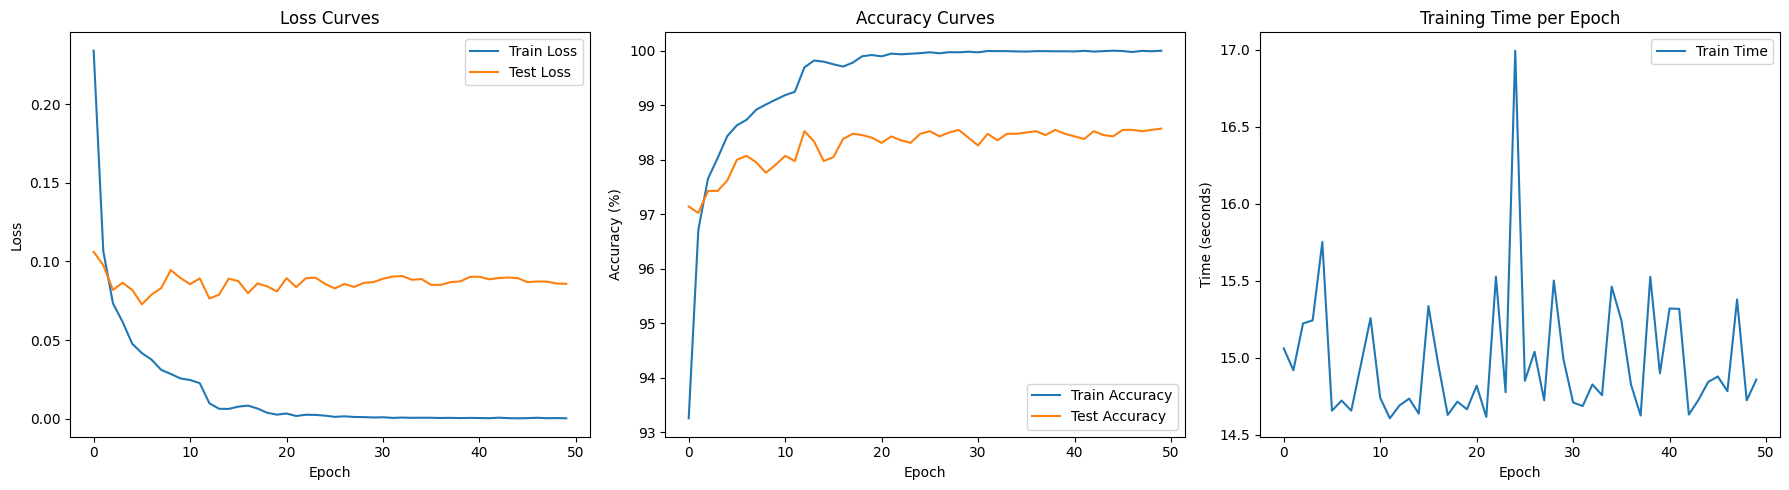

Final Test Accuracy: 98.57%
Average Training Time per Epoch: 14.98 seconds


In [15]:
# Plot training and testing curves
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_times, label='Train Time')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")
print(f"Average Training Time per Epoch: {sum(train_times)/len(train_times):.2f} seconds")

# Submission image

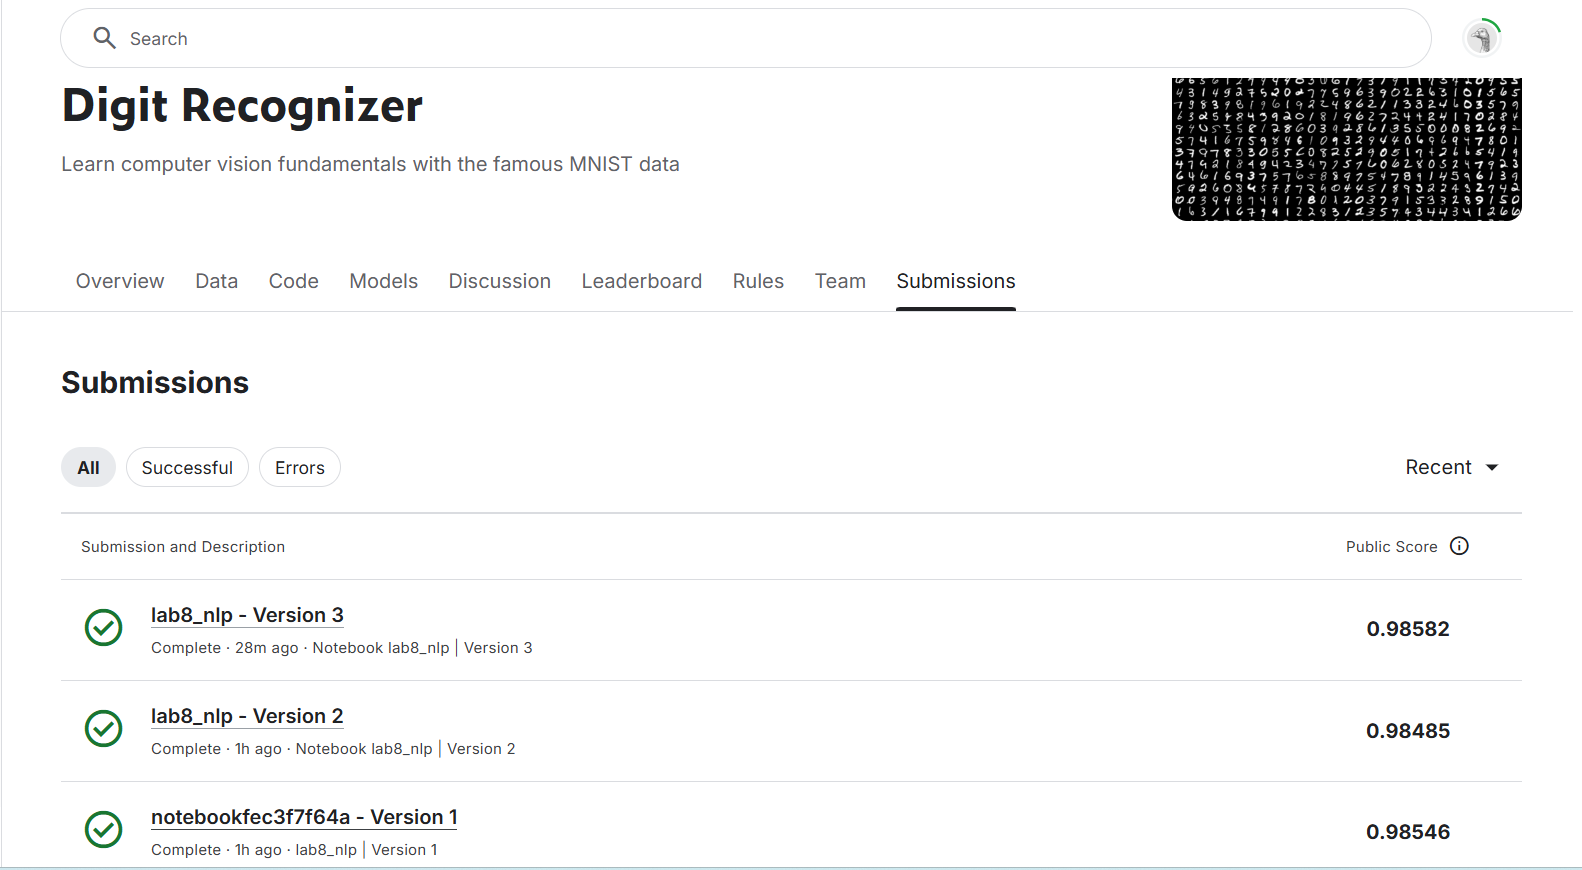